In [26]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math
import autolens as al
from scipy import ndimage
import pandas as pd
import numpy as np
from torchvision.io import read_image
from PIL import Image

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, 15)

In [6]:
model_path = '__local/models/model_alexnet_1m.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', all=False, train=True, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if all:
            self.img_labels = df
        elif train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [8]:
root = "__local/data/Cosmosim/empirical"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None)
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images/processed",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

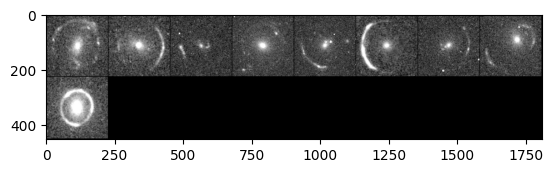

In [9]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

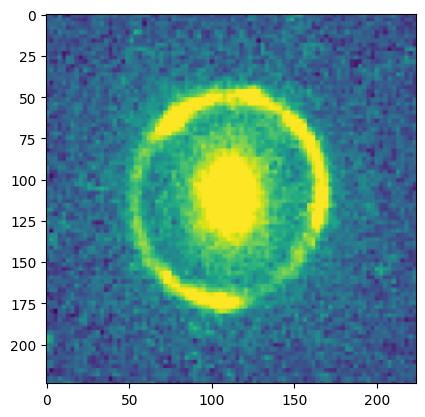

tensor([ 2.1688,  0.5434,  1.1924, -0.0123, -0.1298,  0.0429, -0.0389,  1.4183,
         1.9914,  0.3099,  0.0787, -0.0423, -0.1822, -0.1929,  0.9322],
       grad_fn=<SelectBackward0>)


In [10]:
outputs = model(images)
i = 8
imshow(images[i])
print(outputs[i])

In [11]:
test_data.classes

['r_ein',
 'rdsf_l',
 'r_eff_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'int_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s']

In [12]:
for i in range(len(outputs)):
    print(np.array([
        [outputs[i][0].item(), labels[i][0].item()],
    ]))
    print()

[[3.23410559 1.39999998]]

[[3.02787328 1.29999995]]

[[2.36809421 1.10000002]]

[[2.71950364 2.66000009]]

[[3.09893894 1.95000005]]

[[2.79050064 1.26999998]]

[[2.98058581 1.21000004]]

[[3.17763615 2.02999997]]

[[2.16880393 0.93000001]]



In [63]:
ell_comps = al.convert.ell_comps_from(axis_ratio=0.79, angle=8.1)

print(ell_comps)

(0.0327308001498537, 0.11266015306824469)


In [64]:
al.convert.axis_ratio_and_angle_from(ell_comps=(0.0327308001498537, 0.11266015306824469))

(0.8499999999999999, 62.4)

In [16]:
def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx//fact, sy//fact)
    return res

In [53]:
im = np.array(Image.open('__local/data/Cosmosim/empirical/images/processed/SL2SJ141137+565119.png'))

In [56]:
res = block_mean(im, 4)

In [58]:
res

array([[37.3125, 66.0625, 38.0625, ..., 41.1875, 53.75  , 46.9375],
       [72.625 , 80.875 , 33.8125, ..., 91.125 , 70.875 , 51.5625],
       [69.3125, 71.75  , 64.8125, ..., 96.    , 86.8125, 72.    ],
       ...,
       [36.6875, 55.1875, 70.8125, ..., 62.6875, 56.75  , 71.9375],
       [41.9375, 53.8125, 65.6875, ..., 65.875 , 75.6875, 70.5   ],
       [77.9375, 59.875 , 28.5   , ..., 97.375 , 74.25  , 98.125 ]])